---
**Chapter 03**
# **Introduction to Keras and TensorFlow**
---

In [16]:
# System Libraries
import tensorflow as tf
import numpy as np
import importlib
import sys

sys.path.append("../")
from modules import Common, Chapter_03

# Reload Libraries
importlib.reload(Common)
importlib.reload(Chapter_03)

# Class Instances
chapter_03 = Chapter_03.Chapter_03()
constant = Chapter_03.Constant()

# Check GPU
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---
# **Use Cases**
---

|  **TensorFlow** | **Description** |
|---|---|
| Variable | tf.Variable, tf.constant |
| Mathematics | tf.matmul |
| Backpropagation | tf.GradientTape |
|  **Keras** | **Description** |
| Layers| tf.keras.layers |
| Loss | tf.keras.losses |
| Metrics | tf.keras.metrics |
| Optimizer | tf.keras.optimizers |
|**Concepts**| **Description** |
| Computation Graphs | Calculate gradient of a variable using automatic differentation |
| TensorFlow Hub | Pretrained models |

---
# **Tensor Variable and Constant**
---

In [17]:
# Constant
tf.zeros(shape=(2, 1))
tf.ones(shape=(2, 2))
tf.random.uniform(shape=(2, 2), minval=0, maxval=1e-3)
tf.random.normal(shape=(2, 2), mean=0.0, stddev=1.0)

# Variable
tf_var1 = tf.Variable(initial_value=tf.ones(shape=(2, 2)))
tf_var2 = tf.Variable(initial_value=tf.random.uniform(shape=(2, 2)))

# Math operations
tf.square(tf_var1)  # Square
tf.sqrt(tf_var1)  # Square root

tf_var1 + tf_var2  # Add (Elementwise)
tf_var1.assign_add(tf_var2)  # tf_var1 += tf_var2

tf_var1 * tf_var1  # Multiply (Elementwise)
tf.matmul(tf_var1, tf_var1)  # Multiply (Dot Product)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[4.7980866, 4.234376 ],
       [3.90655  , 4.090749 ]], dtype=float32)>

---
# **1st Order Gradient**
---

In [18]:
input_const = tf.constant(value=3.0)
with tf.GradientTape() as tape:
    tape.watch(input_const)
    result = tf.square(input_const)
gradient = tape.gradient(result, input_const)

print(input_const)
print(input_const.numpy())
print(result)
print(gradient)

tf.Tensor(3.0, shape=(), dtype=float32)
3.0
tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


---
# **2nd Order Gradient**
---

In [19]:
time = tf.Variable(initial_value=5.0)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position = (1 / 2.0) * (39.78) * (time**2)  # 1/2 * a * t2
    velocity = inner_tape.gradient(position, time)  # a * t
acceleration = outer_tape.gradient(velocity, time)  # a

print(position)
print(velocity)
print(acceleration)

tf.Tensor(497.25, shape=(), dtype=float32)
tf.Tensor(198.9, shape=(), dtype=float32)
tf.Tensor(39.78, shape=(), dtype=float32)


---
# **Dataset**
---

**Dataset**

In [20]:
chapter_03.dataset()

**Exploration**

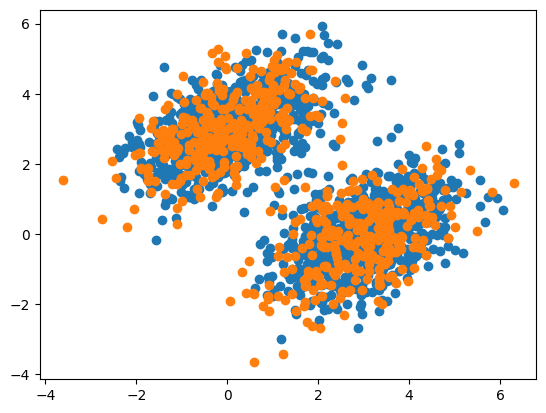

In [21]:
chapter_03.explore()

---
# **Linear Classifier — TensorFlow**
---

**Implementation**

In [22]:
class LinearClassifierTensorFlow:
    def __init__(self, n):
        self.w = tf.Variable(initial_value=tf.random.uniform(shape=(constant.input_dim, constant.output_dim)))
        self.b = tf.Variable(initial_value=tf.zeros(shape=(constant.output_dim)))
        self.n = n

    def fit(self, samples, targets):
        # ---------------------------------------
        # Forward Propagation
        # ---------------------------------------
        with tf.GradientTape() as tape:
            predict_targets = tf.matmul(samples, self.w) + self.b
            predict_loss = tf.reduce_mean(tf.square(targets - predict_targets))
        # ---------------------------------------
        # Backward Propagation
        # ---------------------------------------
        gradient_w, gradient_b = tape.gradient(predict_loss, [self.w, self.b])
        self.w.assign_sub(self.n * gradient_w)
        self.b.assign_sub(self.n * gradient_b)
        return predict_loss

    def evaluate(self, val_samples, targets):
        val_targets = tf.matmul(val_samples, self.w) + self.b
        val_loss = tf.reduce_mean(tf.square(targets - val_targets))
        return val_loss

    def predict(self, samples):
        return tf.matmul(samples, self.w) + self.b


lc_tf = LinearClassifierTensorFlow(constant.n)

**Train**

In [23]:
train_loss_tf, val_loss_tf = [], []
for epoch in range(constant.epochs):
    train_loss_tf.append(lc_tf.fit(chapter_03.x_train, chapter_03.y_train).numpy())
    val_loss_tf.append(lc_tf.evaluate(chapter_03.x_val, chapter_03.y_val).numpy())

**Evaluate**

Train Loss — TF:  0.10673142
Val Loss — TF:  0.113055296


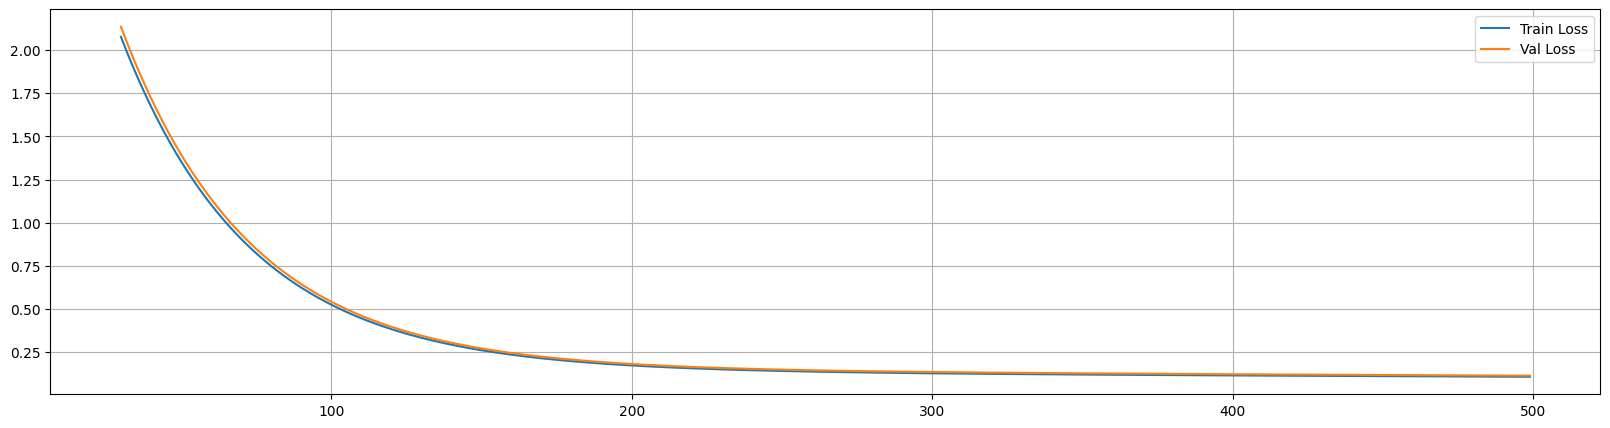

In [24]:
print("Train Loss — TF: ", train_loss_tf[-1])
print("Val Loss — TF: ", val_loss_tf[-1])
Common.plot_simple(data=[train_loss_tf, val_loss_tf], start_index=30)

---
# **Linear Classifier — Keras V1**
---

**General**
- Layer encapsulates state (weight) and function (forward propagation)
- When implementing own layer, put the forward propagation in the call method

**Implementation**

In [25]:
class LinearClassifierKerasV1:
    def __init__(self, n):
        self.rmsprop = tf.keras.optimizers.legacy.RMSprop(learning_rate=n)
        self.mse = tf.keras.losses.MeanSquaredError()
        self.w = tf.Variable(initial_value=tf.random.uniform(shape=(constant.input_dim, constant.output_dim)))
        self.b = tf.Variable(initial_value=tf.zeros(shape=(constant.output_dim,)))
        self.train_history, self.val_history = [], []
        self.epochs = 1500
        self.n = n

    def fit(self, samples, targets, x_val, y_val):
        for _ in range(self.epochs):
            # ---------------------------------------
            # Forward Propagation
            # ---------------------------------------
            with tf.GradientTape() as tape:
                train_predict = tf.matmul(samples, self.w) + self.b
                loss = self.mse(targets, train_predict)
            # ---------------------------------------
            # Backward Propagation
            # ---------------------------------------
            gradients = tape.gradient(loss, [self.w, self.b])
            self.rmsprop.apply_gradients(zip(gradients, [self.w, self.b]))
            # ---------------------------------------
            # Validation
            # ---------------------------------------
            val_predict = tf.matmul(x_val, self.w) + self.b
            val_loss = self.mse(y_val, val_predict)
            # ---------------------------------------
            # History
            # ---------------------------------------
            self.train_history.append(loss)
            self.val_history.append(val_loss)

    def evaluate(self):
        print("---------------------------------------")
        print("Evaluation")
        print("---------------------------------------")
        print("Train Loss — Keras V1: ", self.train_history[-1].numpy())
        print("Val Loss — Keras V1: ", self.val_history[-1].numpy())
        Common.plot_simple(data=[self.train_history, self.val_history], start_index=200)

    def predict(self, samples, ground_targets):
        print("---------------------------------------")
        print("Prediction")
        print("---------------------------------------")
        y_pred = tf.matmul(samples, self.w) + self.b
        print("Ground:")
        for ground_value in ground_targets:
            print(ground_value[0], end=", ")
        print()
        print("Predict: ")
        for predict_value in y_pred.numpy():
            print(abs(np.round(predict_value[0])), end=", ")


lc_keras_v1 = LinearClassifierKerasV1(constant.n)

**Train**

In [26]:
lc_keras_v1.fit(
    chapter_03.x_train,
    chapter_03.y_train,
    chapter_03.x_val,
    chapter_03.y_val,
)

**Evaluate**

---------------------------------------
Evaluation
---------------------------------------
Train Loss — Keras V1:  0.025997737
Val Loss — Keras V1:  0.025806773


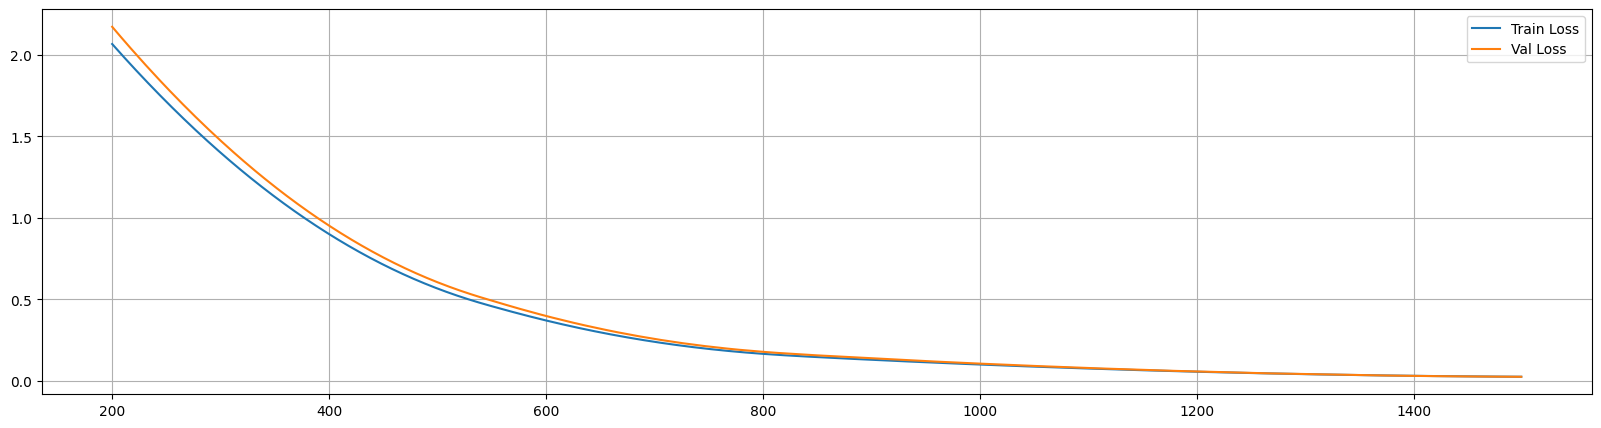

---------------------------------------
Prediction
---------------------------------------
Ground:
0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1

In [27]:
lc_keras_v1.evaluate()
lc_keras_v1.predict(chapter_03.x_val, chapter_03.y_val)

---
# **Linear Classifier — Keras V2**
---

**Implementation**

In [28]:
class LinearClassifierKerasV2:
    def __init__(self, n):
        model = tf.keras.Sequential(tf.keras.layers.Dense(units=1, activation=None))
        model.compile(
            optimizer=tf.keras.optimizers.legacy.RMSprop(n),
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()],
        )
        self.model = model

    def fit(self, samples, targets):
        history = self.model.fit(
            x=samples,
            y=targets,
            epochs=constant.epochs,
            validation_data=(chapter_03.x_val, chapter_03.y_val),
            verbose=False,
        )
        return history

    def evaluate(self, samples, true_targets):
        return self.model.evaluate(x=samples, y=true_targets, verbose=False)

    def predict(self, samples):
        return self.model.predict(x=samples)


lc_keras_v2 = LinearClassifierKerasV2(constant.n)

**Train**

In [29]:
train_loss_kera_v1 = lc_keras_v2.fit(chapter_03.x_train, chapter_03.y_train)

**Evaluate**

Train Loss — Keras V2:  0.024543114006519318
Val Loss — Keras V2:  0.024882419034838676
Metrics: 
loss, mean_absolute_error, val_loss, val_mean_absolute_error, 


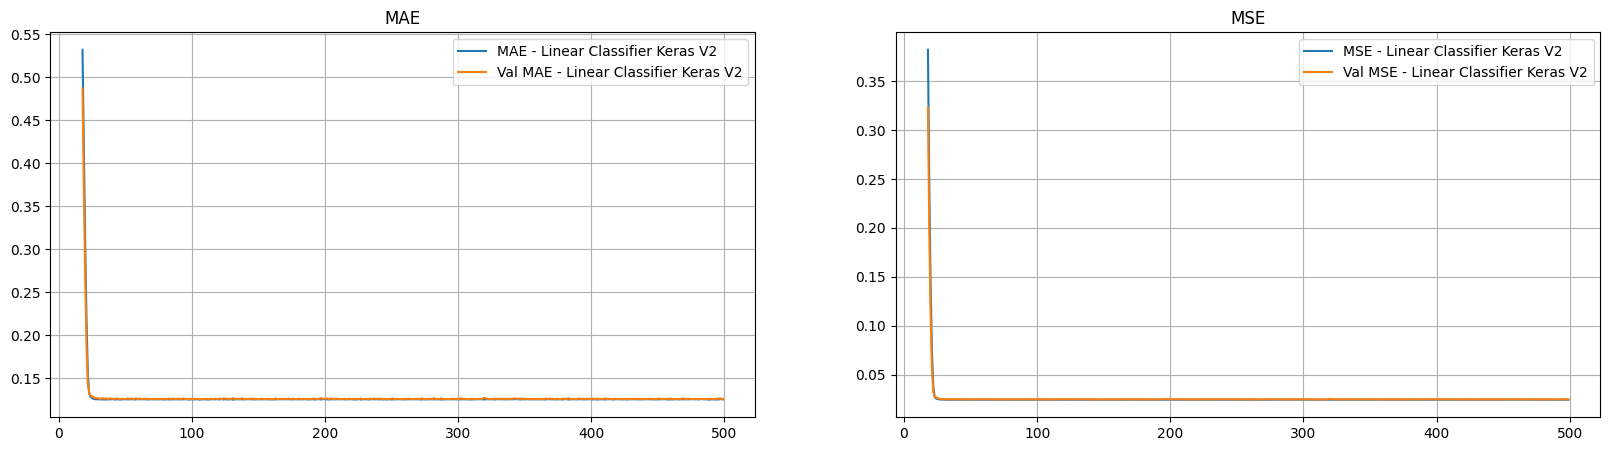

In [30]:
val_loss_kera_v2 = lc_keras_v2.evaluate(chapter_03.x_val, chapter_03.y_val)[0]
print("Train Loss — Keras V2: ", train_loss_kera_v1.history["loss"][-1])
print("Val Loss — Keras V2: ", train_loss_kera_v1.history["val_loss"][-1])
Common.plot(
    data=[train_loss_kera_v1],
    labels=["Linear Classifier Keras V2"],
    window_titles=["MAE", "MSE"],
    start_index=18,
)

---
---
---